## Importing necessary libraries

In [1]:
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.utils import plot_model
from keras.applications import EfficientNetB7
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split

## Spliting the data folder into : Train and Test 

In [2]:
# Set the path to your data directory
data_dir = "C:/Users/DELL/Desktop/datatest/D-E"

In [3]:
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

## Define the model architecture

In [5]:
# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 4
#num_classes = 2

In [6]:
# Load the pre-trained model
base_model = EfficientNetB7(
    weights='imagenet', # Load pre-trained weights from the ImageNet dataset
    include_top=False, # Set to False to exclude the top fully connected layers from the model
    input_shape=(img_width, img_height, 3) # The input shape of the images
)

In [7]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Build a new model on top of the pre-trained VGG16 model
model = Sequential()
model.add(base_model)
# flatten the output of the base model
model.add(Flatten())
# add dense layers with dropout and L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [9]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 flatten (Flatten)           (None, 125440)            0         
                                                                 
 dense (Dense)               (None, 512)               64225792  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

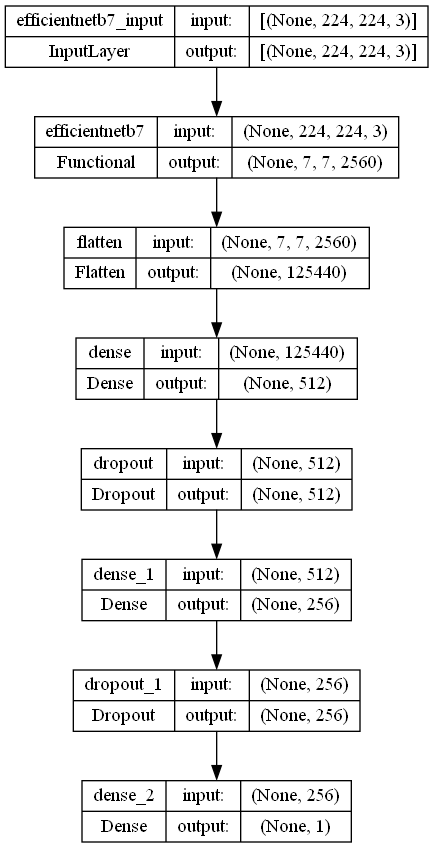

In [10]:
# plot the model architecture
plot_model(model, to_file='B07_model.png', show_shapes=True, show_layer_names=True)

In [11]:
# Compile the model
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [12]:
# Define the data generators for image augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255, # rescales the pixel values to the range [0, 1]
    rotation_range=20, # randomly rotates the images by up to 20 degrees
    width_shift_range=0.1, # randomly shifts the images horizontally by up to 10% of the image width
    height_shift_range=0.1, # randomly shifts the images vertically by up to 10% of the image height
    brightness_range=(0.8, 1.2), # randomly adjusts the brightness of the images by a factor between 0.8 and 1.2
    shear_range=0.2, # randomly applies shearing transformations to the images
    zoom_range=0.2, # randomly applies zooming transformations to the images
    horizontal_flip=True, # randomly flips the images horizontally
    fill_mode='nearest' #  fills in any empty pixels resulting from the transformations using the nearest neighboring pixel value
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Load the training and testing data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary"
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 62 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


In [14]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3)

## Model training

In [15]:
# Train the model
history = model.fit(
    train_data, 
    epochs=10, 
    steps_per_epoch=train_data.n // train_data.batch_size,
    validation_data=test_data,
    validation_steps=test_data.n // test_data.batch_size,
    callbacks=[early_stop]
)

Epoch 1/10
15/15 [==============================] - 96s 5s/step - loss: 16.3028 - accuracy: 0.4500 - val_loss: 14.5654 - val_accuracy: 0.4833
Epoch 2/10
15/15 [==============================] - 60s 4s/step - loss: 16.7116 - accuracy: 0.6207 - val_loss: 18.0350 - val_accuracy: 0.4833
Epoch 3/10
15/15 [==============================] - 60s 4s/step - loss: 19.1670 - accuracy: 0.5000 - val_loss: 14.2993 - val_accuracy: 0.5167
Epoch 4/10
15/15 [==============================] - 62s 4s/step - loss: 18.5351 - accuracy: 0.4828 - val_loss: 14.3913 - val_accuracy: 0.5167
Epoch 5/10
15/15 [==============================] - 62s 4s/step - loss: 16.7519 - accuracy: 0.5345 - val_loss: 14.4571 - val_accuracy: 0.5167
Epoch 6/10
15/15 [==============================] - 63s 4s/step - loss: 15.6304 - accuracy: 0.5517 - val_loss: 14.3069 - val_accuracy: 0.4833


## Plot the training and validation loss and accuracy over the epochs

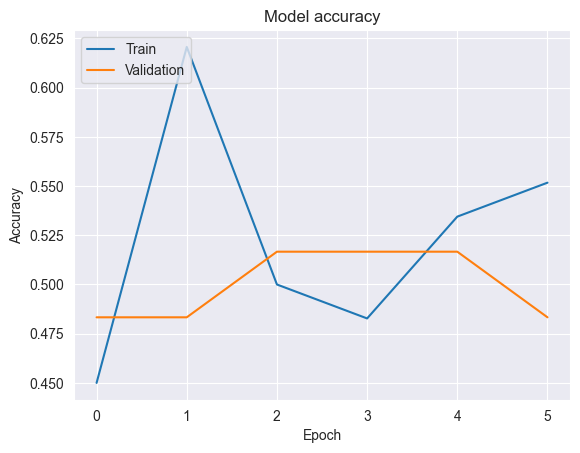

In [16]:
# Set the Seaborn style
sns.set_style("darkgrid")
# Plot the training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

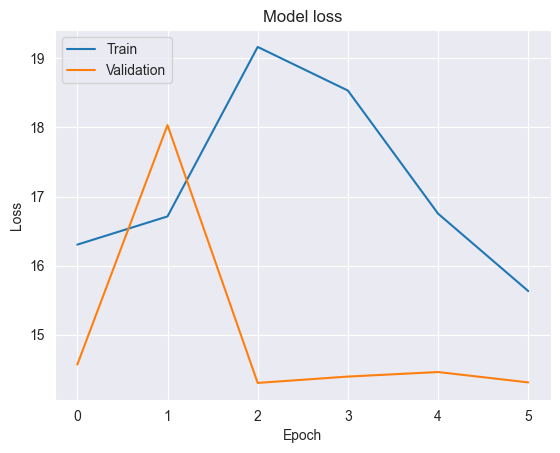

In [17]:
# Set the Seaborn style
sns.set_style("darkgrid")
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the accuracy plot to a file
plt.savefig('B07_accuracy.png')
# Save the accuracy plot to a file
plt.savefig('B07_loss.png')

## Confusion matrix

In [ ]:
# Predict the classes for the validation data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes for the validation data
y_true = test_data.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues')